In [1]:
import datetime
tick = datetime.datetime.now()
# on colab with a GPU, running this complete notebook will take about 25 minutes

[run in colab](https://colab.research.google.com/github/raoulg/tmoi-ml-20/blob/master/4-tuning_dnn/tuning_dnn.ipynb)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/raoulg/tmoi-ml-20/blob/master/4-tuning_dnn/tuning_dnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [2]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf 
import numpy as np
from tensorflow import keras
import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization, Reshape
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import requests
import sys
sys.path.insert(0, "..") 
from src.data import make_dataset
from src.visualization import visualize
from src.models import train_model
from sklearn.preprocessing import StandardScaler
%load_ext tensorboard

In [3]:
# use this to remove old logs folders if you want to run it again.
#!rm -rf logs/fit

In [4]:
# # When running on a location without the utils.py file, download it.
# files = !ls
# if 'utils.py' not in files:
#     file = "https://raw.githubusercontent.com/raoulg/tmoi-ml-20/master/4-tuning_dnn/utils.py"
#     req = requests.get(file)
#     url_content = req.content
#     csv_file = open('utils.py', 'wb')
#     csv_file.write(url_content)
#     csv_file.close()
# from utils import *

In [5]:
# install some missing libraries if running on colab
# notify the user if GPU is off

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !pip install keras-tuner
    !pip install tensorflow-addons

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU was detected.


# Loading data
We start with the MNIST. We already know from the last lesson how easy (or difficult) it is to get a certain performance, so we can evaluate the impact of the different types of activations, batchnorm and dropout.

In [6]:
X_train, y_train, X_valid, y_valid, X_test, y_test = make_dataset.get_mnist(split=0.4, seed=42, validation=True)

In [11]:
result = {}
score = {}

 # Convolutions and Hypermodel

In the next lesson, we will dive into the theory behind *convolutions* and *maxpooling*. For now, let's just try to add these new types of layers to see their effect.

- a `Conv2D` layer expects (as the name suggests) **2D data**, but with an additional dimension for color / grayscale. So, every example has shape (batchsize x height x width) which does not have a channel defined. So we need to add an additional dimension, to specify that we have just one channel for color. We can do this with either reshape, or just with `Input(shape=[28,28,1])`. We will end with a **4D shape** for all data, eg (batchsize x height x width x channels)
- We can tune the amount of filters (first argument) and the size of the kernel (second argument). In this example, I have fixed the kernel size at 3, and set the amount of filters as a hyperparameters to be tuned by the model.
- After a convolution, you can add a `MaxPool2D` layer. Again, **4D shapes** are expected (1D for batch, 2D imagedimensions with 1D for channels).
- the amount of combinations of Conv2d and MaxPool2D is something that we will hypertune.
- After we are finished with convolutions and pooling, we want to pass the result to our `Dense` layers. However, they still expect the data to have a shape (batchsize x features), so we need to **flatten the 2D shape** into a 1D feature vector.
- For the `Dense` layers, we will add `BatchNormalization` and `Dropout`. The amount of dropout is a hyperparameter to tune.

In [12]:
log_dir = "logs/fit/" + "cnn"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model = train_model.get_baseline_conv()

result['conv'] = model.fit(
    X_train, y_train, 
    epochs=100, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop, tbcb], 
    verbose = 0
    )
score['conv'] = model.evaluate(X_test, y_test)

125/125 [==============================] - 1s 3ms/step - loss: 0.0514 - accuracy: 0.9852


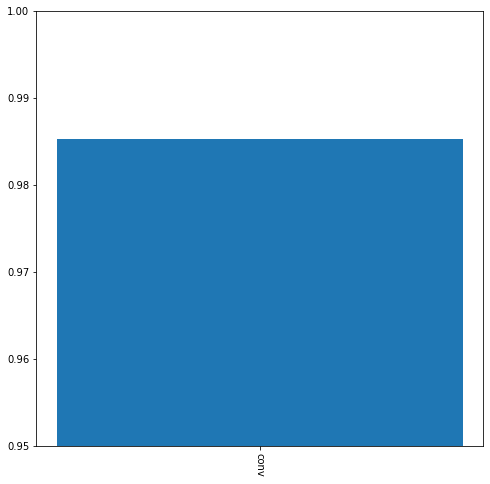

In [13]:
visualize.plot_scores(score, ymin=0.95)

So, while this (again) improves what we have, we run into a real problem. We just have too many options to test.
In addition to that, they might interact. So, we could manually tune the amount of units, but maybe the optimal value is different when we toss in a `Conv2D` layer!
The same holds for everything else we tested. How to get an idea of the search space you are looking at? Let's list a reasonable amount of values we would want to test:

* activations: relu, selu, elu, gelu, leakyrelu (5)
* alpha: leakyrelu with alpha, between 0 and 0.2 (20)
* units: between 32 and 256, or maybe up to 1024 (~50)
* layers: starting from 3, maybe up to 10, or even 100? (~20)
* convlayers: filters between (3,3) and (7,7) (~4)
* combinations of conv and maxpool layers: 1 to 5 (~4)
* batchnorm yes or no (2)
* dropout between 0 and 40 (5)
* learning rate: between $10^{-2}$ and $10^{-5}$ (20)

so we get 5x20x50x20x4x4x2x5x20=320 million combinations! That is way too much to explore with a gridsearch. This searchspace is still way too big to explore with a stochastic hyperparameter tuner, because it can only sample a limited number of combinations! An often adopted compromise is to start exploring the search space manually, and start tuning the hyperparameters only when a promising direction for improvement has been identified.

In addition, exploring the search space manually will give you an intuition of what effect each hyperparameter has on the model preformance, thus helping you understand how your model behaves.


In [15]:
import kerastuner as kt
# takes about 10 minutes with max_epochs=5 and factor=3
# takes about 5 minutes with max_epochs=3 and factor=2

tuner = kt.Hyperband(
    train_model.get_cnn_model,
    objective='val_loss',
    max_epochs=2, # increasing this increases the total amount of trials
    factor=3, # decreasing this will increase the amount of total trials
    seed=10, # adding a random seed here, guarantees you get the same outcome.
    hyperband_iterations=1, # this runs the hyperband multiple times, from scratch, when increased.
    overwrite=True, # overwrites old runs, so you don't need to remove the folder.
    directory='ktuner',
    project_name='mnist'
)
tuner.search(X_train, y_train, validation_data = (X_valid, y_valid), verbose=1)

Trial 2 Complete [00h 00m 55s]
val_loss: 0.04528054967522621

Best val_loss So Far: 0.04528054967522621
Total elapsed time: 00h 02m 05s
INFO:tensorflow:Oracle triggered exit


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
cnn_model = tuner.get_best_models()[0]
cnn_model.summary()

{'filters': 32, 'conv_layers': 1, 'units': 192, 'drops': 0.30313774804008115, 'leak': 0.18112793523490414, 'dense_layers': 2, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                

In [18]:
%%time 
tf.random.set_seed(42)
log_dir = "logs/fit/" + "hyper"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
result['hyper'] = cnn_model.fit(
    X_train, y_train, 
    epochs=100, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop, tbcb], 
    verbose = 0
    )

CPU times: user 9min 18s, sys: 6min 1s, total: 15min 19s
Wall time: 4min 8s


In [19]:
score['hyper'] = cnn_model.evaluate(X_test, y_test)

125/125 [==============================] - 1s 3ms/step - loss: 0.0299 - accuracy: 0.9920


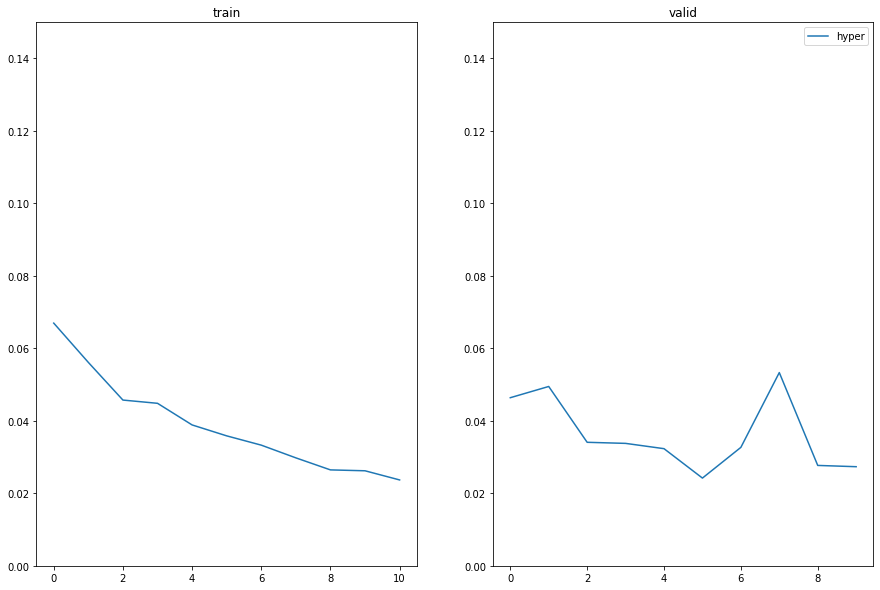

In [20]:
visualize.plot_results(result, ymin=0, ymax = 0.15, subset='drop|hyper')

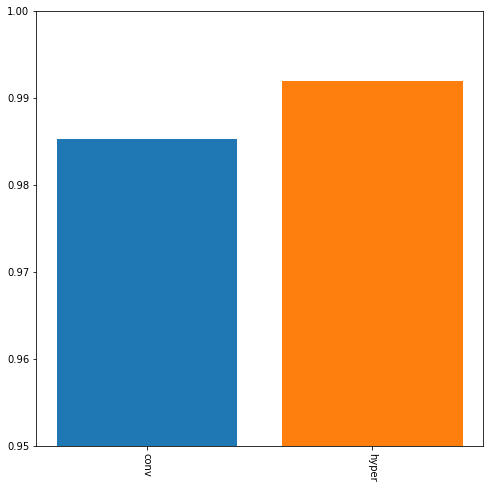

In [21]:
visualize.plot_scores(score, ymin=0.95)

In [22]:
from kerastuner import HyperParameters
hp = HyperParameters()
# you can fix some of the values to decrease the size of the search space
# lets fix the units and the conv_layers, because I'm most confident about those values.
# This way, the hyperband can focus on exploring the rest
hp.Fixed('units', value=256)
hp.Fixed('conv_layers', value=1)

# takes about 5 minutes with max_epochs=3 and factor=2
tuner = kt.Hyperband(
    train_model.get_cnn_model,
    hyperparameters=hp, # this overwrites the old values with the fixed values
    tune_new_entries=True, # this allows the rest that isn't defined to be trained
    objective='val_loss',
    max_epochs=3, # increasing this increases the total amount of trials
    factor=2, # decreasing this will increase the amount of total trials
    seed=10, # adding a random seed here, guarantees you get the same outcome.
    hyperband_iterations=1, # this runs the hyperband multiple times, from scratch, when increased.
    overwrite=True, # overwrites old runs, so you don't need to remove the folder.
    directory='ktuner',
    project_name='mnist'
)
tuner.search(X_train, y_train, validation_data = (X_valid, y_valid), verbose=1)

Trial 8 Complete [00h 01m 49s]
val_loss: 0.03378676250576973

Best val_loss So Far: 0.03378676250576973
Total elapsed time: 00h 09m 17s
INFO:tensorflow:Oracle triggered exit


In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
model = tuner.get_best_models()[0]

log_dir = "logs/fit/" + "hyper2"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tf.random.set_seed(42)
result['hyper2'] = model.fit(
    X_train, y_train, 
    epochs=100, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop, tbcb], 
    verbose = 0
    )
score['hyper2'] = model.evaluate(X_test, y_test)

{'units': 256, 'conv_layers': 1, 'filters': 48, 'drops': 0.11156555180121402, 'leak': 0.08170717585089876, 'dense_layers': 2, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
125/125 [==============================] - 1s 6ms/step - loss: 0.0302 - accuracy: 0.9912


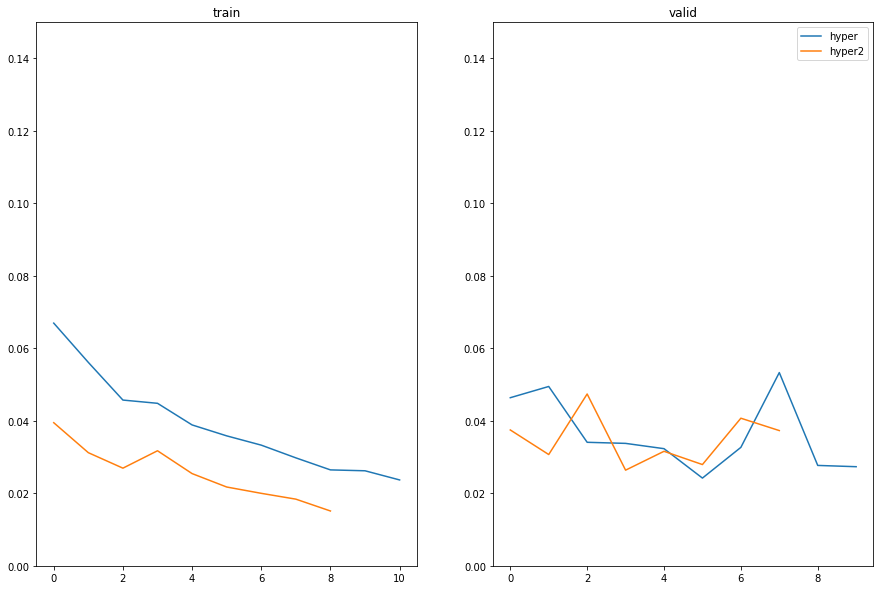

In [24]:
visualize.plot_results(result, ymin=0, ymax = 0.15, subset='drop|hyper')

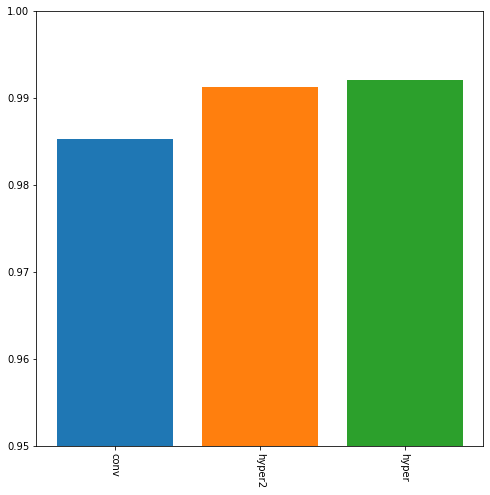

In [25]:
visualize.plot_scores(score, ymin=0.95)

In [ ]:
%tensorboard --logdir logs/fit

# Save your model
After all this hard work and tuning, save your model.

In [ ]:
model.save('mymodel.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('mymodel.h5')

# Check its architecture
model.summary()

In [ ]:
model.evaluate(X_test, y_test)